In [ ]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

: 

In [2]:
import json
import logging
from pathlib import Path

import numpy as np
import polars as pl
import torch

from src.log_config import configure_logging
from src.models.data_loader import create_dataloaders
from src.models.data_preparation import (
    expand_feature_list,
    load_data_from_database,
    prepare_data,
)
from src.models.main_config import RANDOM_SEED
from src.models.utils import load_model
from src.plots.model_performance import (
    get_model_predictions,
    plot_multiple_pr_curves,
    plot_multiple_roc_curves,
    plot_single_roc_curve,
)

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado", "filelock"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials

polars.config.Config

In [3]:
feature_lists = [
    ["eda_raw"],
    ["heart_rate"],
    ["pupil"],
    ["eda_raw", "pupil"],
    ["eda_raw", "heart_rate"],
    ["eda_raw", "heart_rate", "pupil"],
    ["face"],
    ["face", "eda_raw", "heart_rate", "pupil"],
    ["eeg"],
    ["eeg", "eda_raw"],
    ["eeg", "face", "eda_raw", "heart_rate", "pupil"],
]
feature_lists = expand_feature_list(feature_lists)
feature_list = feature_lists[0]
feature_list_str = "_".join(feature_list)

In [4]:
results = {}
winning_models = {}

feature_list_str = "_".join(feature_list)
# Load data from database
df = load_data_from_database(feature_list=feature_list)

# Load model
json_path = Path(f"results/experiment_{feature_list_str}/results.json")
dictionary = json.loads(json_path.read_text())
model_path = Path(dictionary["overall_best"]["model_path"].replace("\\", "/"))

model, feature_list, sample_duration_ms, intervals, label_mapping, offsets_ms = (
    load_model(model_path, device="cpu")
)
winning_models[feature_list_str] = {feature_list_str: model.__class__.__name__}

# Prepare data
X_train, y_train, X_val, y_val, X_train_val, y_train_val, X_test, y_test = prepare_data(
    df=df,
    feature_list=feature_list,
    sample_duration_ms=sample_duration_ms,
    intervals=intervals,
    label_mapping=label_mapping,
    offsets_ms=offsets_ms,
    random_seed=RANDOM_SEED,
)
test_groups = prepare_data(
    df=df,
    feature_list=feature_list,
    sample_duration_ms=sample_duration_ms,
    intervals=intervals,
    label_mapping=label_mapping,
    offsets_ms=offsets_ms,
    random_seed=RANDOM_SEED,
    only_return_test_groups=True,
)
_, test_loader = create_dataloaders(
    X_train_val, y_train_val, X_test, y_test, batch_size=64
)

00:34:06 | INFO    | utils | Using device: cpu
00:34:06 | INFO    | utils | Loaded PatchTST model with test accuracy 0.76 to cpu
00:34:06 | INFO    | utils | Input shape: (70, 1) | Features: ['eda_raw'] | Sample duration: 7000 ms
00:34:06 | DEBUG   | utils | Intervals: {'increases': 'strictly_increasing_intervals', 'plateaus': 'plateau_intervals', 'decreases': 'major_decreasing_intervals'}
00:34:06 | DEBUG   | utils | Label mapping: {'increases': 0, 'plateaus': 0, 'decreases': 1}
00:34:06 | DEBUG   | utils | Offset ms: {'increases': 0, 'plateaus': 5000, 'decreases': 1000}
00:34:06 | DEBUG   | sample_creation | Removed 749 samples with less than 69 data points
00:34:06 | DEBUG   | data_preparation | Preparing data with sample duration 7000 ms and random seed 40
00:34:06 | DEBUG   | data_preparation | Samples are based on intervals: {'increases': 'strictly_increasing_intervals', 'plateaus': 'plateau_intervals', 'decreases': 'major_decreasing_intervals'}
00:34:06 | DEBUG   | data_preparat

In [ ]:
from TSInterpret.InterpretabilityModels.counterfactual.NativeGuideCF import (
    NativeGuideCF,
)

exp_model = NativeGuideCF(
    model, (X_train, y_train), backend="PYT", mode="feat", method="NUN_CF"
)

In [ ]:
exp, label = exp_model.explain(item, np.argmax(y_target, axis=1)[0])

In [ ]:
from TSInterpret.InterpretabilityModels.counterfactual.COMTECF import COMTECF

exp_model = COMTECF(model, (X_train, y_train), backend="PYT", mode="feat", method="opt")


: 

In [ ]:
exp = exp_model.explain(item)

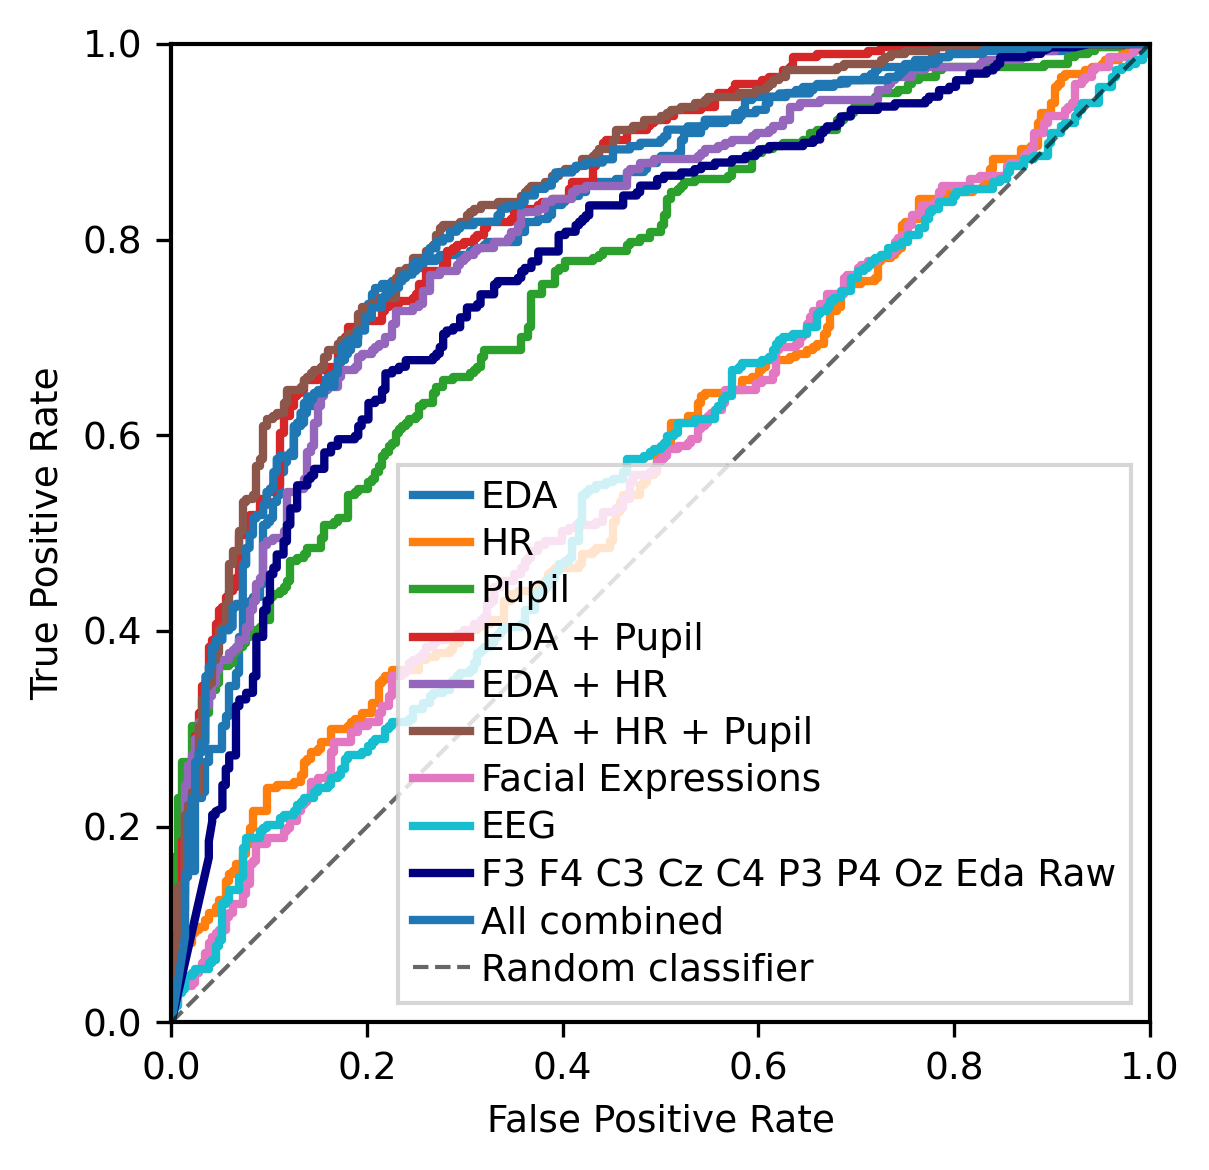

In [9]:
roc_curves = plot_multiple_roc_curves(results)


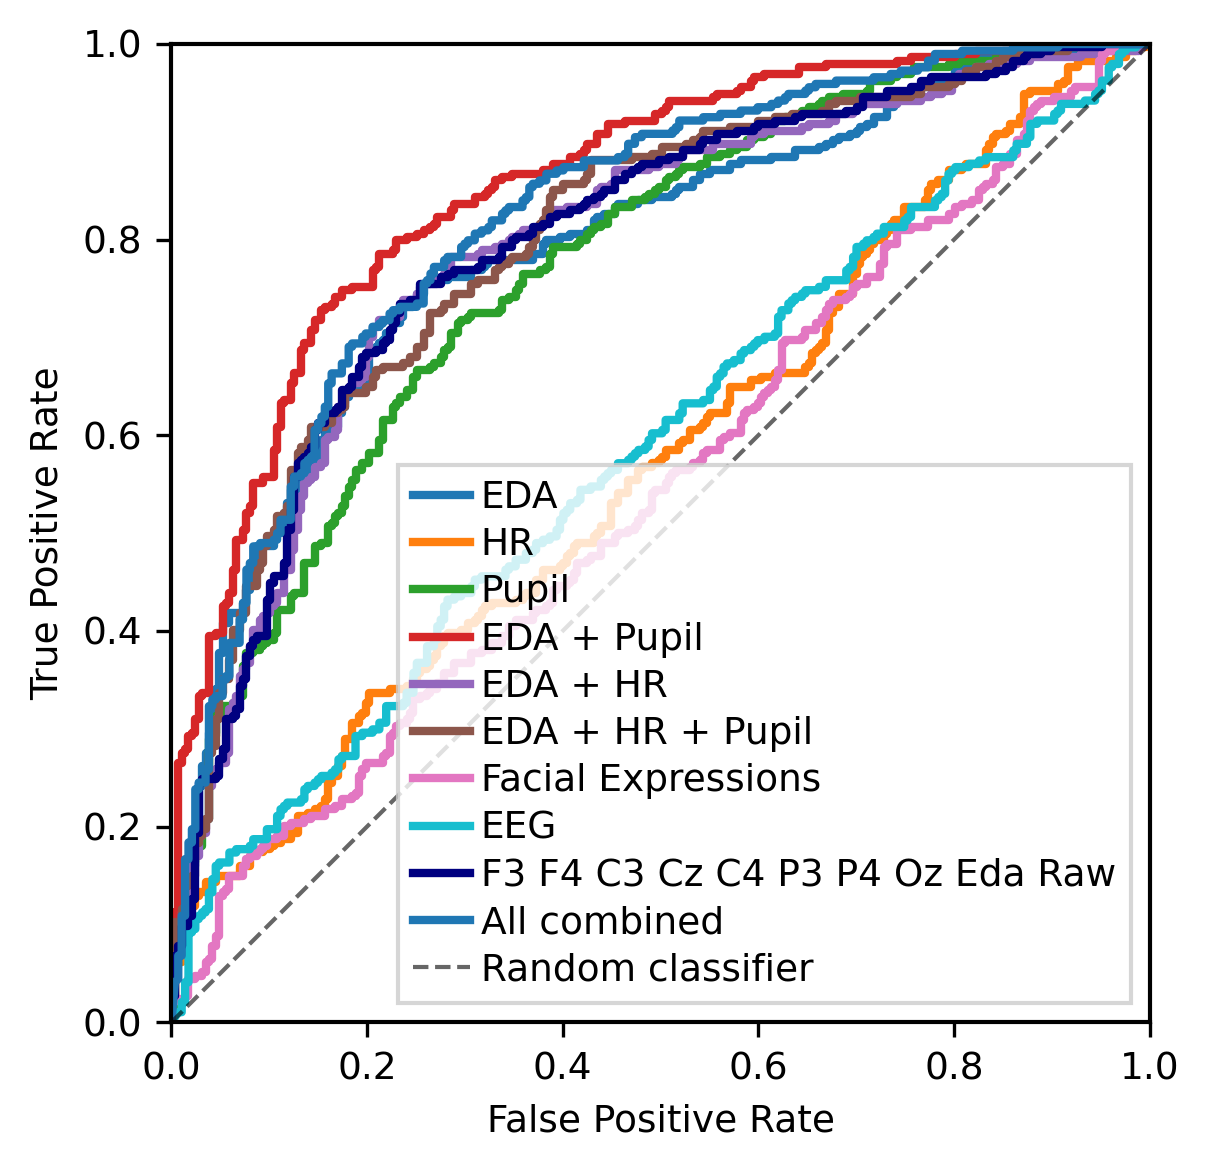

In [8]:
roc_curves = plot_multiple_roc_curves(results)


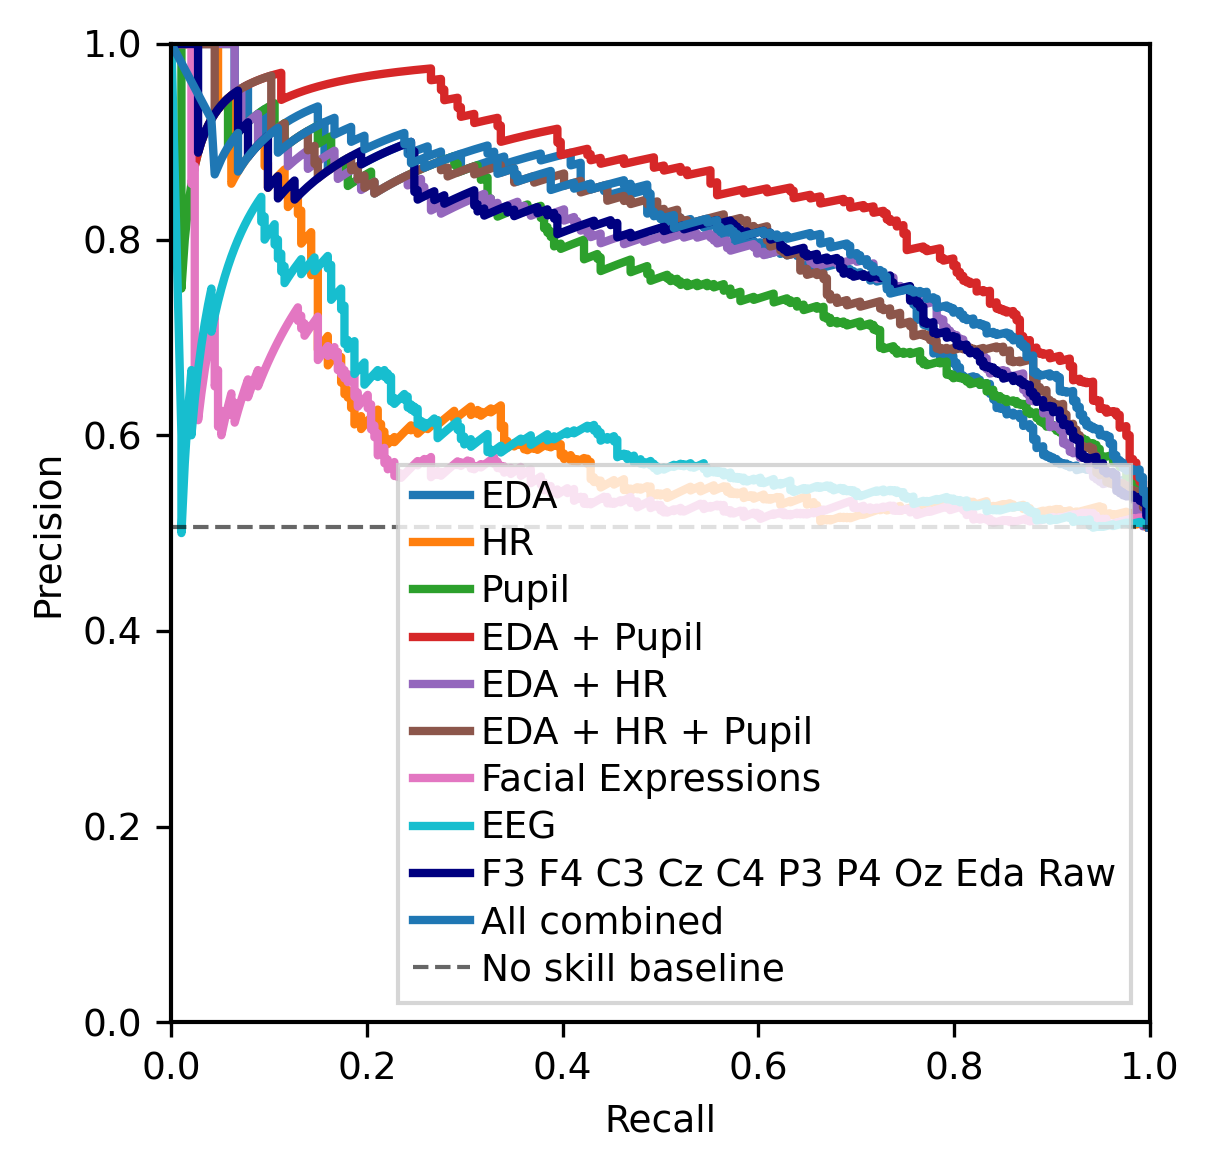

In [9]:
pr_curves = plot_multiple_pr_curves(results)


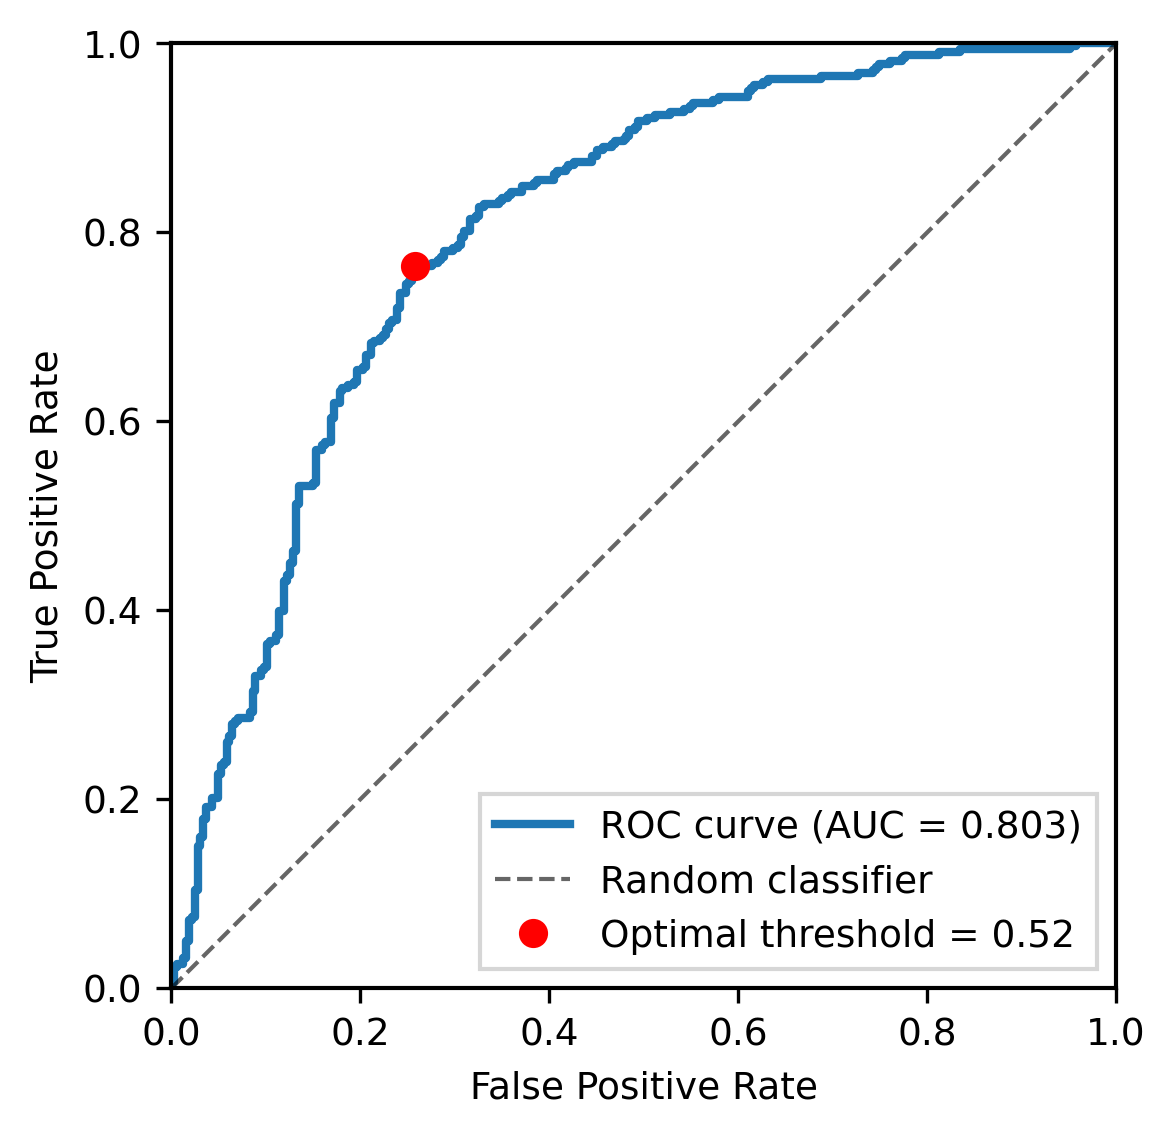

In [ ]:
single_roc_curve = plot_single_roc_curve(results["eda_raw"][0], results["eda_raw"][1])

In [ ]:
probs, y_true = get_model_predictions(
    model,
    test_loader,
)

In [ ]:
conf_matrix_05 = get_confusion_matrix(probs, y_true, threshold=0.5)
conf_matrix_08 = get_confusion_matrix(probs, y_true, threshold=0.7)

NameError: name 'get_confusion_matrix' is not defined

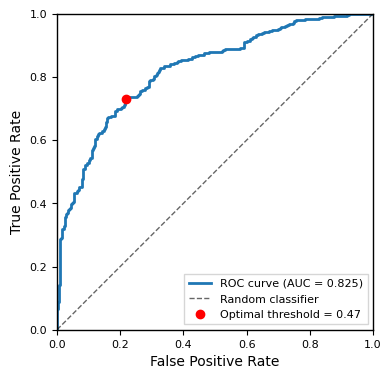

In [ ]:
single_roc_curve = plot_single_roc_curve(probs, y_true)

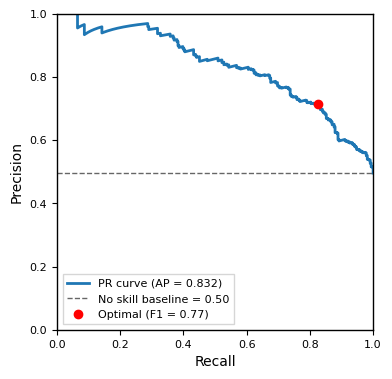

In [ ]:
single_pr_curve = plot_single_pr_curve(probs, y_true)  # ap = average precision